<a href="https://colab.research.google.com/github/tarikaytek/image-segmentation-with-linknet-implementation/blob/main/link_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow.keras import layers
import random

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
dataset.keys()

dict_keys(['train', 'test'])

In [ ]:
dataset['train']

<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [ ]:
train_labels = []
train_species = []

for e in dataset['train']:
  train_species.append(int(e['species']))
  train_labels.append(int(e['label']))

test_labels = []
test_species = []

for e in dataset['test']:
  test_species.append(int(e['species']))
  test_labels.append(int(e['label']))

len(train_labels), len(train_species), len(test_labels), len(test_species)

(3680, 3680, 3669, 3669)

In [ ]:
from collections import Counter

train_labels_counter = Counter(sorted(train_labels))
train_species_counter = Counter(sorted(train_species))
test_labels_counter = Counter(sorted(test_labels))
test_species_counter = Counter(sorted(test_species))

for e in train_labels_counter:
  print(e, train_labels_counter[e])
print('##########################################')

for e in train_species_counter:
  print(e, train_species_counter[e])
print('##########################################')

for e in test_labels_counter:
  print(e, test_labels_counter[e])
print('##########################################')

for e in test_species_counter:
  print(e, test_species_counter[e])

0 100
1 100
2 100
3 100
4 100
5 100
6 100
7 96
8 100
9 100
10 100
11 93
12 96
13 100
14 100
15 100
16 100
17 100
18 100
19 100
20 100
21 100
22 96
23 100
24 100
25 100
26 100
27 100
28 100
29 100
30 100
31 100
32 99
33 100
34 100
35 100
36 100
##########################################
0 1188
1 2492
##########################################
0 98
1 100
2 100
3 100
4 100
5 100
6 100
7 88
8 99
9 100
10 100
11 97
12 100
13 100
14 100
15 100
16 100
17 100
18 99
19 100
20 100
21 100
22 100
23 100
24 100
25 100
26 100
27 100
28 100
29 100
30 99
31 100
32 100
33 100
34 89
35 100
36 100
##########################################
0 1183
1 2486


In [ ]:
IMG_SIZE = (256,256)
SPLIT = 0.7
BATCH_SIZE = 64
#BUFFER_SIZE = 1000
N_CLASSES = 3

In [ ]:
def load(data, img_size=IMG_SIZE):
    img = tf.image.resize(data['image'], size=img_size) / 255.
    mask = tf.image.resize(data['segmentation_mask'], size=img_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) -1
    return img, mask

def split(dataset, split_ratio=SPLIT, buffer_size=tf.data.AUTOTUNE):
    train_size = int(len(dataset) * split_ratio)
    dataset.shuffle(len(dataset))
    train = dataset.take(train_size)
    val = dataset.skip(train_size)

    return train, val

train = dataset['train'].map(load)
test = dataset['test'].map(load)

train, val = split(dataset=train, split_ratio=SPLIT)

In [ ]:
train_batches = train.cache().batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.AUTOTUNE)
val_batches = val.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
len(train), len(test), type(train), len(val)

(2576, 3669, tensorflow.python.data.ops.dataset_ops.TakeDataset, 1104)

In [ ]:
def create_model():

    #function that returns output of conv layer consists of 3 layers: 
    # 2D convolution with given parameters, batch normalization, relu activation function
    def conv_layer(input, filters, kernel_size, strides=1, padding='same'):
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(input)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        return x

    #function that returns output of full-conv(transposed conv) layer consists of 3 layers:
    #transposed 2d convolution with given parameters, batch normalization, relu activation function
    def full_conv_layer(input, filters, kernel_size, strides=2, padding='same'):

        x = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(input)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        return x

    #function that returns output of an encoder block as its described in paper
    def encoder_block(input, filters, strides_of_first_conv=2):
        

        res = conv_layer(input, filters, 1, strides=strides_of_first_conv)

        x = conv_layer(input, filters, 3, strides=strides_of_first_conv)
        x = conv_layer(x, filters, 3)
        
        x = layers.Add()([x, res])

        res = x

        x = conv_layer(x, filters, 3)
        x = conv_layer(x, filters, 3)

        x = layers.Add()([x, res])

        return x
    
    #function that returns  output of a decoder block as its described in paper
    def decoder_block(input, filters, strides_of_full_conv=2):

        x = conv_layer(input, filters/2, 1)

        x = full_conv_layer(x, filters/2, 3, strides=strides_of_full_conv)

        x = conv_layer(x, filters, 1)

        return x
    
    ####### needed methods has implemented, creating model using these functions below.

    #initializing input tensor in proper shape
    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

    ###initial layer 
    x = conv_layer(input=inputs, filters=64, kernel_size=7, strides=2)
    x = layers.MaxPooling2D(pool_size=2)(x)

    ###encoder blocks
    #saving their outputs to use it in residual connections
    encoder_1_output = encoder_block(input=x, filters=64, strides_of_first_conv=1)
    encoder_2_output = encoder_block(input=encoder_1_output, filters=128)
    encoder_3_output = encoder_block(input=encoder_2_output, filters=256)
    encoder_4_output = encoder_block(input=encoder_3_output, filters=512)

    ###decoder blocks
    #residual connections is made here by tf.layers.Add function which adds given tensors 
    
    #decoder block 4
    x = decoder_block(input=encoder_4_output, filters=256)
    #decoder block 3
    x = layers.Add()([x, encoder_3_output])
    x = decoder_block(input=x, filters=128)
    #decoder block 2
    x = layers.Add()([x, encoder_2_output])
    x = decoder_block(input=x, filters=64)
    #decoder block 1
    x = layers.Add()([x, encoder_1_output])
    x = decoder_block(input=x, filters=64, strides_of_full_conv=1)

    ###final block
    x = full_conv_layer(input=x, filters=32, kernel_size=3)
    x = conv_layer(input=x, filters=32, kernel_size=3)
    #output layer
    outputs = layers.Conv2DTranspose(filters=N_CLASSES, kernel_size=2, strides=2, activation='softmax', padding='same')(x)

    model = tf.keras.Model(inputs, outputs)
    return model
    

model = create_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from numpy.core.memmap import uint8
from tensorflow.keras import backend as K
import numpy as np

def dice_coef(y_true, y_pred):
    pred_mask = create_mask(y_pred)
    pred_mask = tf.cast(pred_mask, tf.float32)
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.flatten(pred_mask)

    intersect = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    dice = (2. * intersect + K.epsilon()) / (union + K.epsilon())
    dice = K.mean(dice)
    
    return dice
  
def dice_loss(y_true, y_pred):
  return 1. - dice_coef(y_true, y_pred)

def create_mask(y_pred):
  pred_mask = tf.math.argmax(y_pred, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

import matplotlib.pyplot as plt

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


  

In [ ]:
EPOCHS=30
STEPS_PER_EPOCH = len(train) / BATCH_SIZE
VAL_SUBSPLITS = 5
VALIDATION_STEPS= len(val) / BATCH_SIZE / VAL_SUBSPLITS

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
]

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['accuracy', dice_coef])
hist = model.fit(train_batches, validation_data=val_batches, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, callbacks=callbacks)

Epoch 1/30
40/40 [==============================] - 43s 783ms/step - loss: 0.8382 - accuracy: 0.6340 - dice_coef: 0.8306 - val_loss: 1.0427 - val_accuracy: 0.4553 - val_dice_coef: 0.3901
Epoch 2/30
40/40 [==============================] - 29s 719ms/step - loss: 0.6151 - accuracy: 0.7632 - dice_coef: 0.9451 - val_loss: 1.0158 - val_accuracy: 0.4871 - val_dice_coef: 0.4080
Epoch 3/30
40/40 [==============================] - 28s 698ms/step - loss: 0.5404 - accuracy: 0.7906 - dice_coef: 0.9984 - val_loss: 1.2636 - val_accuracy: 0.4235 - val_dice_coef: 0.2781
Epoch 4/30
40/40 [==============================] - 29s 720ms/step - loss: 0.4753 - accuracy: 0.8165 - dice_coef: 1.0256 - val_loss: 0.6905 - val_accuracy: 0.7142 - val_dice_coef: 0.8366
Epoch 5/30
40/40 [==============================] - 29s 721ms/step - loss: 0.4190 - accuracy: 0.8397 - dice_coef: 1.0521 - val_loss: 0.6465 - val_accuracy: 0.7458 - val_dice_coef: 0.8949
Epoch 6/30
40/40 [==============================] - 28s 715ms/ste

In [ ]:
def plot(metric):
  train = hist.history[metric]
  val = hist.history['val_' + metric]

  plt.figure()
  plt.plot(hist.epoch, train, 'r', label='training ' + metric)
  plt.plot(hist.epoch, val, 'bo', label='validation ' + metric)
  plt.title('training and validation ' + metric)
  plt.xlabel('epoch')
  plt.ylabel(metric + ' value')
  #plt.ylim([0, 1])
  plt.legend()
  plt.show()


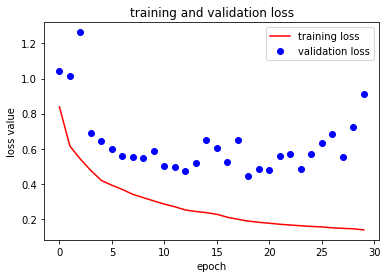

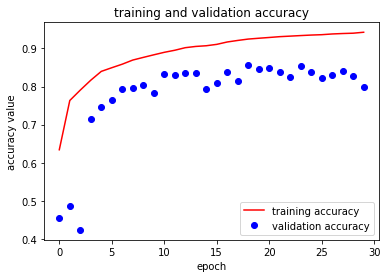

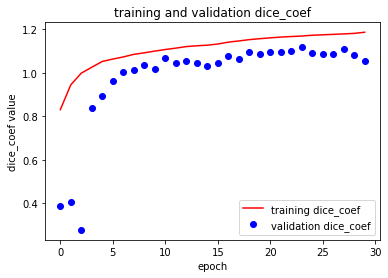

In [ ]:
plot('loss')
plot('accuracy')
plot('dice_coef')

In [ ]:
result = model.evaluate(test_batches)

print('loss in test data:', result[0])
print('accuracy in test data:', result[1])
print('dice coefficient in test data:', result[2])

58/58 [==============================] - 16s 279ms/step - loss: 0.9218 - accuracy: 0.7979 - dice_coef: 1.0610
loss in test data: 0.921836256980896
accuracy in test data: 0.797875702381134
dice coefficient in test data: 1.0609967708587646


In [ ]:
for e in hist.history:
  l = hist.history[e]
  print('max ' + e, max(l))
  print('avg ' + e, sum(l) / len(l))
  print('final ' + e, l[-1], '\n')

max loss 0.8381895422935486
avg loss 0.2817732175191244
final loss 0.13722942769527435 

max accuracy 0.94242262840271
avg accuracy 0.887828016281128
final accuracy 0.94242262840271 

max dice_coef 1.1863049268722534
avg dice_coef 1.1104512294133504
final dice_coef 1.1863049268722534 

max val_loss 1.2635688781738281
avg val_loss 0.6335119783878327
final val_loss 0.9138665795326233 

max val_accuracy 0.8574456572532654
avg val_accuracy 0.7795506159464518
final val_accuracy 0.7990348935127258 

max val_dice_coef 1.118249535560608
avg val_dice_coef 0.9790302485227584
final val_dice_coef 1.0553864240646362 



2/2 [==============================] - 0s 101ms/step


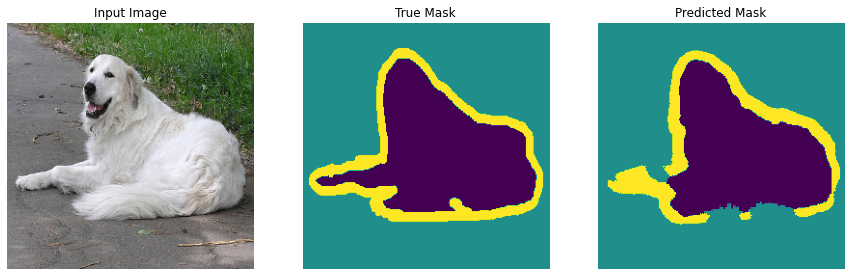

2/2 [==============================] - 0s 79ms/step


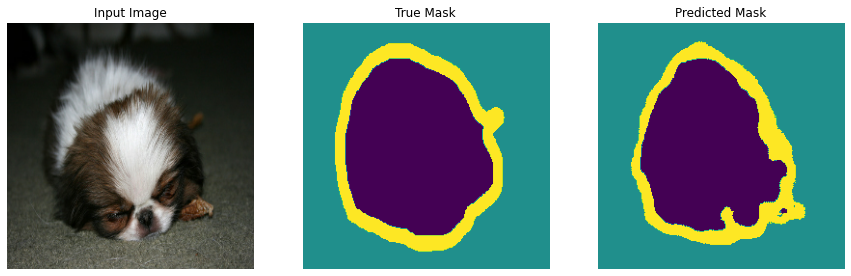

2/2 [==============================] - 0s 83ms/step


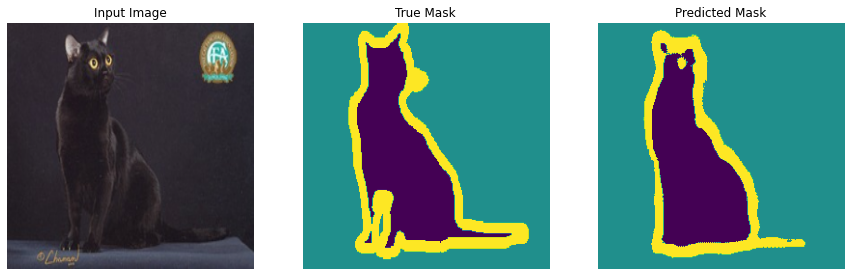

2/2 [==============================] - 0s 78ms/step


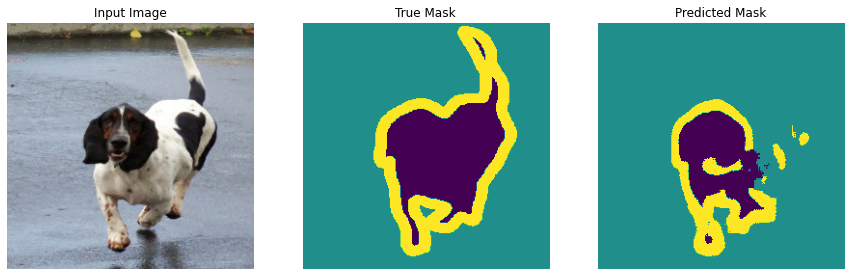

2/2 [==============================] - 0s 82ms/step


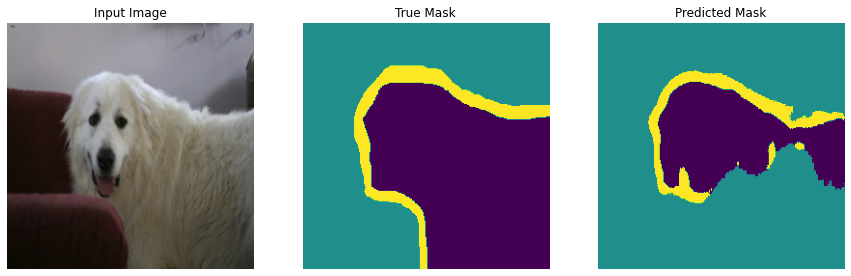

In [ ]:
num_of_samples = 5

for img, mask in test_batches.take(num_of_samples):
  pred = model.predict(img)
  pred_mask = create_mask(pred)
  i = random.randint(0, BATCH_SIZE)
  display([img[i], mask[i], pred_mask[i]])

In [ ]:
print('YAY')

YAY
